# Compare prediction

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import string
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts
from tree.utils import linestyles, markers

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

with open("../data/splits/random_val.json", "r") as f:
    train_inds, val_inds, test_inds = json.load(f)

num_training = len(train_inds)

val_df = hbi_unc_df.loc[val_inds, :]
val_df = val_df.reset_index(drop=True)

# Load test results

In [55]:
sidt_df_dict = {}
thresholds = [0.00005, 0.0001, 0.0002, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
run_dirs = {
    "../models/split-random_val_run-model_variance_prepruning_hyperparam_opt-upper_bound": "MP$\lambda$_UB",
}
for run_dir in run_dirs:
    for threshold in thresholds:
        thres = f"{threshold:f}".rstrip("0")
        sidt_df = pd.read_csv(f"{run_dir}/lambda-{thres}/validation.csv")
        sidt_df_dict[run_dir, threshold] = sidt_df

# Get tree size

In [56]:
tree_sizes = {}
for run_dir in run_dirs:
    for threshold in thresholds:
        thres = f"{threshold:f}".rstrip("0")
        tree_path = f"{run_dir}/lambda-{thres}/tree.py"
        with open(tree_path, "r") as f:
            lines = f.readlines()
            tree_size = sum("index = " in line for line in lines)
            tree_sizes[run_dir, threshold] = tree_size
            
# tree_sizes

# Get RMSE/MAE

In [57]:
temp_dict = {
    "threshold": [],
    "run_dir": [],
    "tree_size": [],
}

for column in val_df.columns:
    if column.startswith("HBI_"):
        temp_dict["rmse_"+column] = []
        temp_dict["mae_"+column] = []
        temp_dict["bounded_"+column] = []

for (run_dir, threshold), sidt_df in sidt_df_dict.items():
    temp_dict["threshold"].append(threshold)
    temp_dict["run_dir"].append(run_dir)
    temp_dict["tree_size"].append(tree_sizes[run_dir, threshold])
    for column in val_df.columns:
        if column.startswith("HBI_"):
            true_ys = val_df[column]
            pred_ys = sidt_df[column]
            temp_dict["rmse_"+column].append(np.sqrt(mean_squared_error(true_ys, pred_ys)))
            temp_dict["mae_"+column].append(mean_absolute_error(true_ys, pred_ys))
            
            pred_unc = sidt_df["unc_"+column]
            true_err = (sidt_df[column] - val_df[column]).abs()
            data_unc = val_df["unc_"+column]
            temp_dict["bounded_"+column].append(sum((pred_unc >= true_err)) / len(pred_unc))

result_df = pd.DataFrame(temp_dict)
result_df

,threshold,run_dir,tree_size,rmse_HBI_H298 (kcal/mol),mae_HBI_H298 (kcal/mol),bounded_HBI_H298 (kcal/mol),rmse_HBI_Sint298 (cal/mol/K),mae_HBI_Sint298 (cal/mol/K),bounded_HBI_Sint298 (cal/mol/K),rmse_HBI_Cp300 (cal/mol/K),...,bounded_HBI_Cp600 (cal/mol/K),rmse_HBI_Cp800 (cal/mol/K),mae_HBI_Cp800 (cal/mol/K),bounded_HBI_Cp800 (cal/mol/K),rmse_HBI_Cp1000 (cal/mol/K),mae_HBI_Cp1000 (cal/mol/K),bounded_HBI_Cp1000 (cal/mol/K),rmse_HBI_Cp1500 (cal/mol/K),mae_HBI_Cp1500 (cal/mol/K),bounded_HBI_Cp1500 (cal/mol/K)
0,0.00005,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
1,0.00010,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
2,0.00020,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
3,0.00050,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
4,0.00060,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
5,0.00070,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
6,0.00080,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
7,0.00090,../models/split-random_val_run-model_variance_...,3236,8.532761,4.138178,0.774545,7.056897,4.669764,0.607273,2.474276,...,0.770909,2.936252,1.943418,0.789091,2.776774,1.807130,0.814545,2.612132,1.662266,0.821818
8,0.00100,../models/split-random_val_run-model_variance_...,1753,10.462822,6.490820,0.861818,6.097090,4.248542,0.770909,2.335408,...,0.825455,2.678789,1.777528,0.861818,2.581499,1.697382,0.858182,2.622539,1.657653,0.832727
9,0.00200,../models/split-random_val_run-model_variance_...,1149,10.407454,6.628970,0.883636,5.980289,4.230617,0.821818,2.167213,...,0.850909,2.545299,1.783545,0.883636,2.471624,1.703824,0.880000,2.605156,1.707537,0.854545


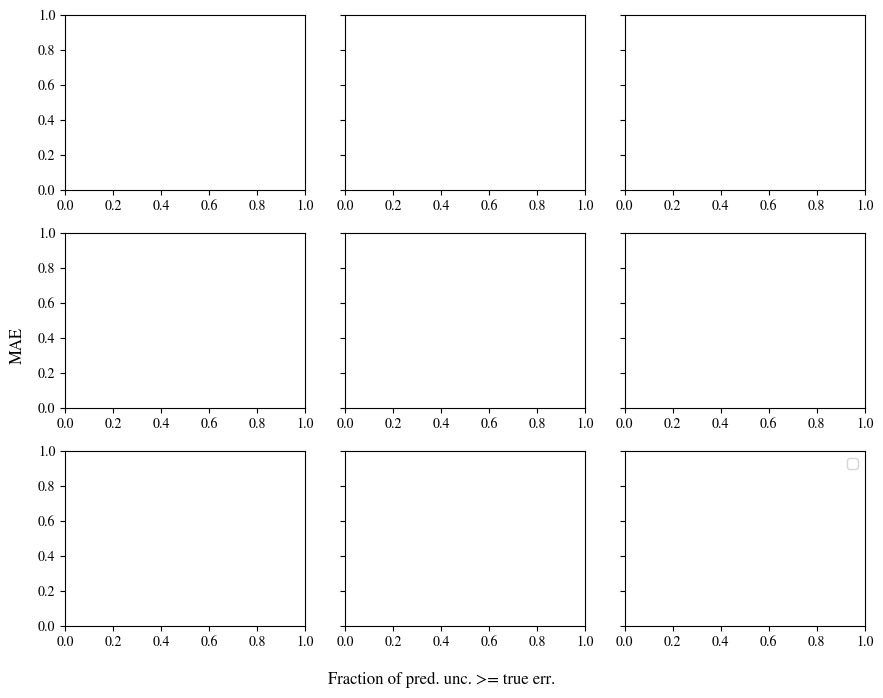

In [58]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
bins = 20

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "bounded_"+label], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Fraction of pred. unc. >= true err.")

fig.tight_layout()
fig.savefig("../figures/mae_vs_bounded_uncertainty_threshold.pdf", bbox_inches="tight")

# Plot: RMSE/MAE vs. thresholds

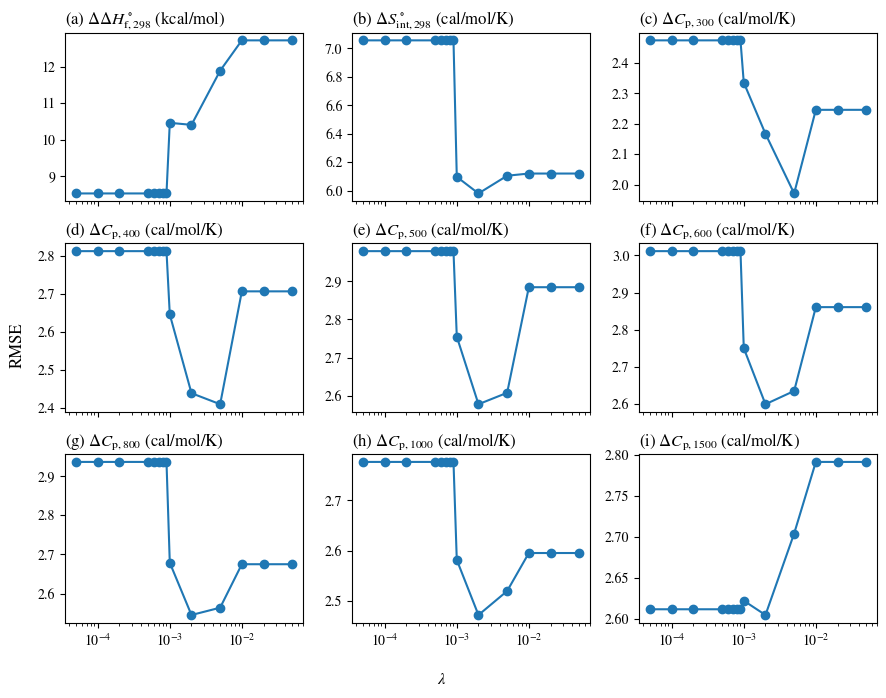

In [59]:
run_dirs_to_plot = run_dirs.values()

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")
        ax.set_xscale("log")
        
        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")
        ax.set_xscale("log")
        
        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            ax.set_xscale("log")

        counter += 1

fig.supylabel(f"RMSE")
fig.supxlabel("$\lambda$")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_MP_threshold.pdf", bbox_inches="tight")

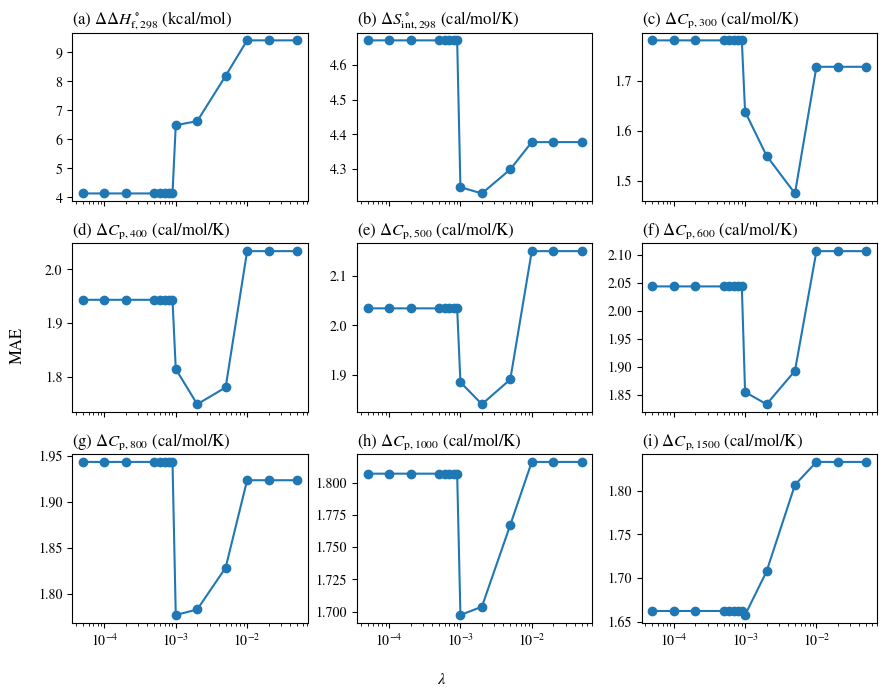

In [60]:
run_dirs_to_plot = run_dirs.values()

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")
        ax.set_xscale("log")
        
        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")
        ax.set_xscale("log")
        
        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            ax.set_xscale("log")

        counter += 1

fig.supylabel(f"MAE")
fig.supxlabel("$\lambda$")

fig.tight_layout()
fig.savefig("../figures/mae_vs_MP_threshold.pdf", bbox_inches="tight")

# Plot tree size vs. thresholds

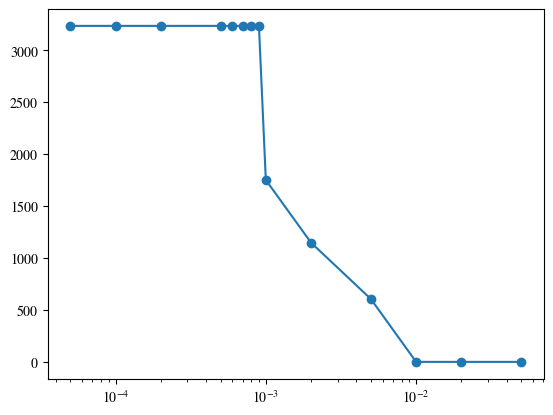

In [61]:
run_dirs_to_plot = run_dirs.values()

plt.figure()
plt.plot(result_df.loc[result_df["run_dir"]==run_dir, "threshold"], result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], "-o")
plt.xscale("log")
plt.savefig("../figures/tree_size_vs_MP_thresholds.pdf", bbox_inches="tight")

# Plot: RMSE/MAE vs. tree size

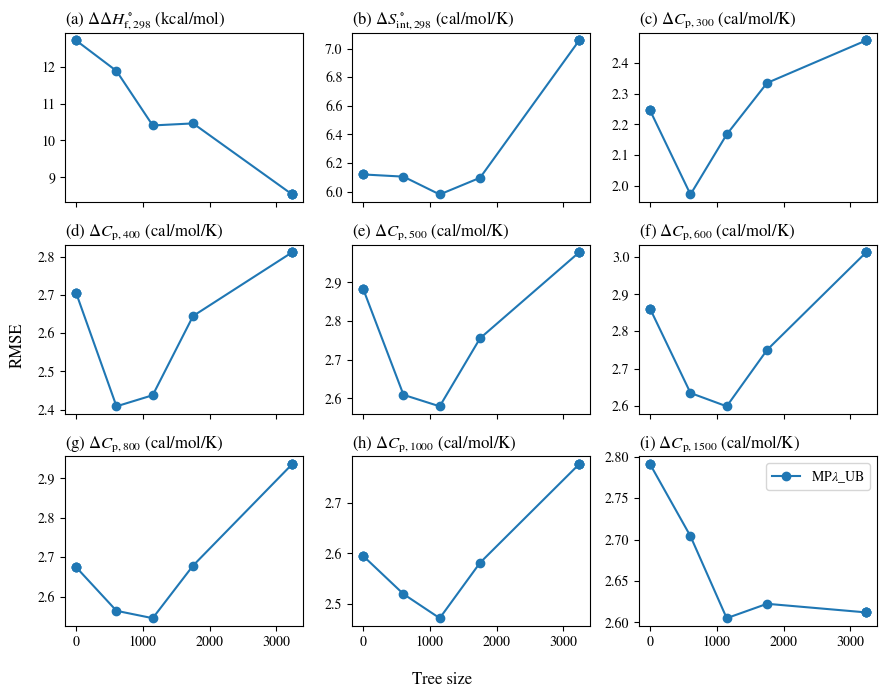

In [49]:
run_dirs_to_plot = run_dirs.values()

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_MP_thresholds.pdf", bbox_inches="tight")

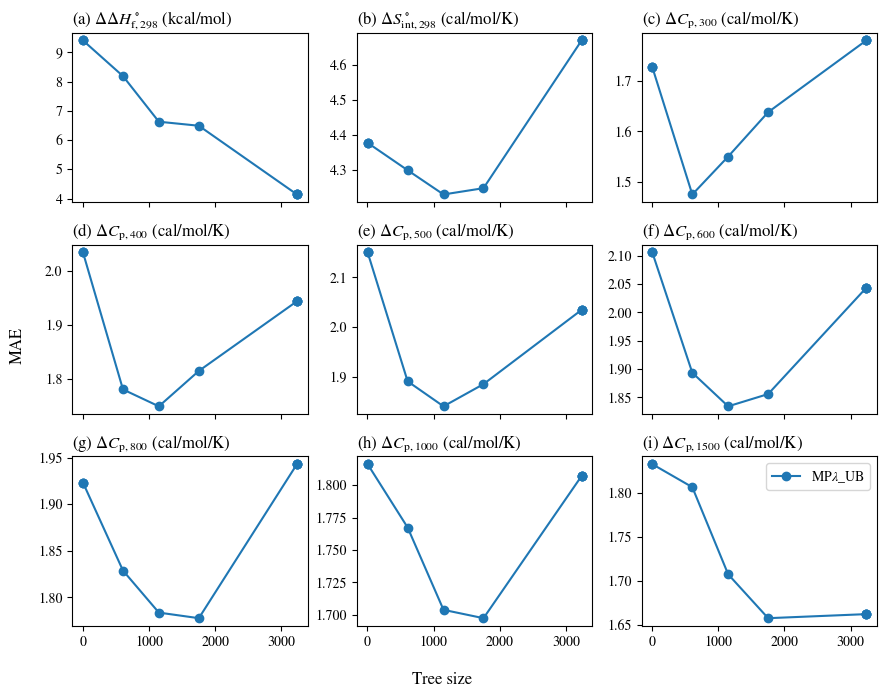

In [50]:
run_dirs_to_plot = run_dirs.values()

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/mae_vs_tree_size_MP_thresholds.pdf", bbox_inches="tight")